# ML Assignment 2: Classification Models Comparison

**Student Name:** VISWANATHA REDDY M

**Student ID:** 2025AA05375

**Requirements:**
- Dataset: Minimum 12 features, 500+ instances
- Models: 6 classification algorithms
- Metrics: Accuracy, AUC, Precision, Recall, F1 Score, MCC Score

## 1. Import Required Libraries

Import all the required libraries for data processing, visualization, and evaluation.

In [1]:
# Data processing and analysis
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Scikit-learn libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation metrics
from sklearn.metrics import (accuracy_score, roc_auc_score, precision_score, 
                             recall_score, f1_score, matthews_corrcoef,
                             confusion_matrix, classification_report, roc_curve)

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Load and Explore Dataset

**Dataset:** Breast Cancer Wisconsin (Diagnostic) Dataset  

**Source:** Kaggle

**Features:** 30 numerical features + 1 ID column

**Instances:** 569 instances

**Target:** Binary classification (M = Malignant, B = Benign)

In [2]:
# Read the dataset - Breast Cancer Wisconsin dataset
df = pd.read_csv('../Data/Kaggle_Breast_Cancer_Wisconsin_data.csv')

# Print the dataset shape and sizes (basic information)
print(f"Dataset Shape: {df.shape}")
print(f"Number of Features: {df.shape[1] - 2}")  # Feature count, excluding 'id' and 'diagnosis'
print(f"Number of Instances: {df.shape[0]}")

# Drop the column 'id' as it is not useful for prediction
print(f"\nColumns in dataset: {df.columns.tolist()}")

# Check if there's an unnamed column
if 'Unnamed: 32' in df.columns or df.columns[-1].startswith('Unnamed'):
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    print(f"\nRemoved unnamed columns")

# Drop the 'id' column
df = df.drop('id', axis=1)

print(f"\nDataset Shape after removing ID: {df.shape}")
print("\nFirst few rows:")
df.head()

Dataset Shape: (569, 33)
Number of Features: 31
Number of Instances: 569

Columns in dataset: ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32']

Removed unnamed columns

Dataset Shape after removing ID: (569, 31)

First few rows:


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
# Dataset information
print("Dataset Information:")
print("=" * 80)
df.info()
print("\n" + "=" * 80)
print("\nStatistical Summary:")
df.describe()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [4]:
# Check if there are any missing values
print("Missing Values:")
print(df.isnull().sum())
print(f"\nTotal missing values: {df.isnull().sum().sum()}")

# Encode target variable
# M (Malignant) = 1, B (Benign) = 0
label_encoder = LabelEncoder()
df['diagnosis'] = label_encoder.fit_transform(df['diagnosis'])
print("\nTarget encoding:")
print("  - B (Benign) = 0")
print("  - M (Malignant) = 1")

# Check class distribution
print("\nTarget Variable Distribution:")
print(df['diagnosis'].value_counts())
print(f"\nClass Balance:")
print(df['diagnosis'].value_counts(normalize=True))

Missing Values:
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

Total missing values: 0

Target encoding:
  - B (Benign) = 0
  - M (Mal

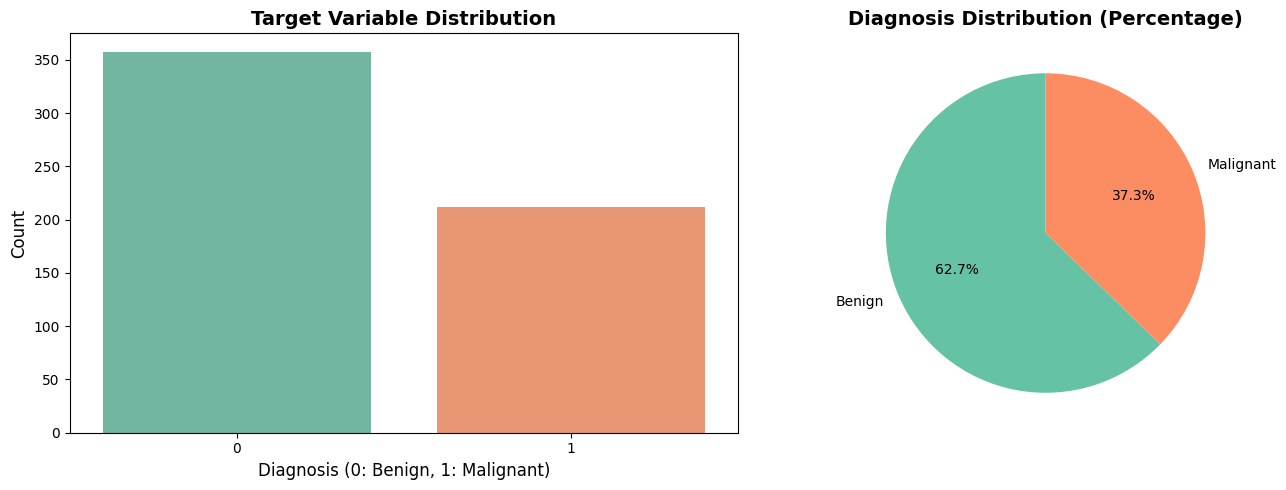

In [5]:
# Display the target distribution information
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot bar chart for target variable distribution counts
sns.countplot(data=df, x='diagnosis', ax=axes[0], palette='Set2')
axes[0].set_title('Target Variable Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Diagnosis (0: Benign, 1: Malignant)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)

# Plot pie chart for target variable distribution counts
target_counts = df['diagnosis'].value_counts()
axes[1].pie(target_counts, labels=['Benign', 'Malignant'], autopct='%1.1f%%', 
            startangle=90, colors=sns.color_palette('Set2'))
axes[1].set_title('Diagnosis Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 3. DAta processing and feature engineering

Perform:
1. Handling missing values
2. Detecting and handling outliers
3. Feature scaling and normalization
4. Encoding categorical variables

In [6]:
# Handle Missing Values
print("Step 1: Handling Missing Values")
print("=" * 80)

# Check missing values
missing_before = df.isnull().sum().sum()
print(f"Total missing values before imputation: {missing_before}")

# Impute missing values
# For numerical columns: use median
if df.isnull().sum().sum() > 0:
    # Separate numerical and categorical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numerical_cols.remove('diagnosis')  # Remove target variable
    
    # Impute numerical columns with median
    imputer_num = SimpleImputer(strategy='median')
    df[numerical_cols] = imputer_num.fit_transform(df[numerical_cols])
    
    print(f"Total missing values after imputation: {df.isnull().sum().sum()}")
else:
    print("No missing values found!")

print("✓ Missing values handled successfully")

Step 1: Handling Missing Values
Total missing values before imputation: 0
No missing values found!
✓ Missing values handled successfully


## 4. Prepare Data for Modeling

Split the data into features (X) and target (y), then split into training and testing sets.

In [7]:
# Separate features and target
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

print("Feature Matrix Shape:", X.shape)
print("Target Vector Shape:", y.shape)
print(f"\nTotal number of features: {X.shape[1]}")
print("\nFirst 10 features:")
print(X.columns.tolist()[:10])

Feature Matrix Shape: (569, 30)
Target Vector Shape: (569,)

Total number of features: 30

First 10 features:
['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']


In [8]:
# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                      random_state=42, stratify=y)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)
print("\nTarget distribution in training set:")
print(y_train.value_counts(normalize=True))
print("\nTarget distribution in testing set:")
print(y_test.value_counts(normalize=True))

Training set size: (455, 30)
Testing set size: (114, 30)

Target distribution in training set:
diagnosis
0    0.626374
1    0.373626
Name: proportion, dtype: float64

Target distribution in testing set:
diagnosis
0    0.631579
1    0.368421
Name: proportion, dtype: float64


In [9]:
# Feature Scaling - Important for distance-based algorithms
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Feature scaling completed")
print("Scaled features - Mean (should be ~0):", X_train_scaled.mean(axis=0)[:5])
print("Scaled features - Std (should be ~1):", X_train_scaled.std(axis=0)[:5])

✓ Feature scaling completed
Scaled features - Mean (should be ~0): [-1.73731603e-16  3.90408097e-16  4.70441756e-16 -1.17122429e-16
  7.24207019e-16]
Scaled features - Std (should be ~1): [1. 1. 1. 1. 1.]


## 5. Define Evaluation Function

Create a reusable function to calculate all required evaluation metrics for each model.

In [10]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Train and evaluate a classification model with all required metrics
    
    Parameters:
    -----------
    model : classifier object
        The machine learning model to train and evaluate
    X_train, X_test : 
        Training and testing features
    y_train, y_test : array-like
        Training and testing target values
    model_name : str
        Name of the model for display
    
    Returns:
    --------
    dict : Dictionary containing all evaluation metrics
    """
    print(f"\n{'='*80}")
    print(f"Training {model_name}")
    print(f"{'='*80}")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else y_pred
    
    # Calculate all metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    mcc = matthews_corrcoef(y_test, y_pred)
    
    # Print results
    print(f"\n{model_name} Performance Metrics:")
    print(f"  1. Accuracy:  {accuracy:.4f}")
    print(f"  2. AUC Score: {auc:.4f}")
    print(f"  3. Precision: {precision:.4f}")
    print(f"  4. Recall:    {recall:.4f}")
    print(f"  5. F1 Score:  {f1:.4f}")
    print(f"  6. MCC Score: {mcc:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:")
    print(cm)
    
    # Store results
    results = {
        'Model': model_name,
        'Accuracy': accuracy,
        'AUC Score': auc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'MCC Score': mcc,
        'Predictions': y_pred,
        'Probabilities': y_pred_proba
    }
    
    return results

print("✓ Evaluation function defined successfully")

✓ Evaluation function defined successfully


## 6. Model 1: Logistic Regression

Train and evaluate Logistic Regression classifier.

In [11]:
# Initialize and train Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_results = evaluate_model(lr_model, X_train_scaled, X_test_scaled, 
                            y_train, y_test, "Logistic Regression")


Training Logistic Regression

Logistic Regression Performance Metrics:
  1. Accuracy:  0.9649
  2. AUC Score: 0.9960
  3. Precision: 0.9750
  4. Recall:    0.9286
  5. F1 Score:  0.9512
  6. MCC Score: 0.9245

Confusion Matrix:
[[71  1]
 [ 3 39]]


## 7. Model 2: Decision Tree Classifier

Train and evaluate Decision Tree classifier.

In [12]:
# Initialize and train Decision Tree
dt_model = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=5)
dt_results = evaluate_model(dt_model, X_train, X_test, 
                           y_train, y_test, "Decision Tree")


Training Decision Tree

Decision Tree Performance Metrics:
  1. Accuracy:  0.9386
  2. AUC Score: 0.9425
  3. Precision: 0.9268
  4. Recall:    0.9048
  5. F1 Score:  0.9157
  6. MCC Score: 0.8676

Confusion Matrix:
[[69  3]
 [ 4 38]]


## 8. Model 3: K-Nearest Neighbors Classifier

Train and evaluate K-Nearest Neighbors classifier.

In [13]:
# Initialize and train K-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn_results = evaluate_model(knn_model, X_train_scaled, X_test_scaled, 
                            y_train, y_test, "K-Nearest Neighbors")


Training K-Nearest Neighbors

K-Nearest Neighbors Performance Metrics:
  1. Accuracy:  0.9561
  2. AUC Score: 0.9823
  3. Precision: 0.9744
  4. Recall:    0.9048
  5. F1 Score:  0.9383
  6. MCC Score: 0.9058

Confusion Matrix:
[[71  1]
 [ 4 38]]


## 9. Model 4: Naive Bayes Classifier (Gaussian)

Train and evaluate Gaussian Naive Bayes classifier.

In [14]:
# Initialize and train Gaussian Naive Bayes
nb_model = GaussianNB()
nb_results = evaluate_model(nb_model, X_train_scaled, X_test_scaled, 
                           y_train, y_test, "Gaussian Naive Bayes")


Training Gaussian Naive Bayes

Gaussian Naive Bayes Performance Metrics:
  1. Accuracy:  0.9211
  2. AUC Score: 0.9891
  3. Precision: 0.9231
  4. Recall:    0.8571
  5. F1 Score:  0.8889
  6. MCC Score: 0.8292

Confusion Matrix:
[[69  3]
 [ 6 36]]


## 10. Model 5: Random Forest Classifier (Ensemble)

Train and evaluate Random Forest ensemble classifier.

In [15]:
# Initialize and train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_results = evaluate_model(rf_model, X_train, X_test, 
                           y_train, y_test, "Random Forest")


Training Random Forest

Random Forest Performance Metrics:
  1. Accuracy:  0.9737
  2. AUC Score: 0.9929
  3. Precision: 1.0000
  4. Recall:    0.9286
  5. F1 Score:  0.9630
  6. MCC Score: 0.9442

Confusion Matrix:
[[72  0]
 [ 3 39]]


## 11. Model 6: XGBoost Classifier (Ensemble)

Train and evaluate XGBoost ensemble classifier.

In [16]:
# Initialize and train XGBoost
xgb_model = XGBClassifier(n_estimators=100, random_state=42, max_depth=6, 
                         learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
xgb_results = evaluate_model(xgb_model, X_train, X_test, 
                            y_train, y_test, "XGBoost")


Training XGBoost

XGBoost Performance Metrics:
  1. Accuracy:  0.9737
  2. AUC Score: 0.9921
  3. Precision: 1.0000
  4. Recall:    0.9286
  5. F1 Score:  0.9630
  6. MCC Score: 0.9442

Confusion Matrix:
[[72  0]
 [ 3 39]]


In [17]:
# Save all trained models as pickle files
import pickle
import os

# Save models in the same directory as the notebook
print("\nSaving trained models...")
print("=" * 80)

# Dictionary of models to save
models_to_save = {
    'logistic_regression_model.pkl': lr_model,
    'decision_tree_model.pkl': dt_model,
    'knn_model.pkl': knn_model,
    'naive_bayes_model.pkl': nb_model,
    'random_forest_model.pkl': rf_model,
    'xgboost_model.pkl': xgb_model
}

# Save each model in the current directory
for filename, model in models_to_save.items():
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"✓ Saved: {filename}")

# Also save the scaler for future predictions
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)
print(f"✓ Saved: scaler.pkl")

print("=" * 80)
print(f"\nAll models saved successfully in current directory!")
print(f"Total files saved: {len(models_to_save) + 1} (6 models + 1 scaler)")



Saving trained models...
✓ Saved: logistic_regression_model.pkl
✓ Saved: decision_tree_model.pkl
✓ Saved: knn_model.pkl
✓ Saved: naive_bayes_model.pkl
✓ Saved: random_forest_model.pkl
✓ Saved: xgboost_model.pkl
✓ Saved: scaler.pkl

All models saved successfully in current directory!
Total files saved: 7 (6 models + 1 scaler)


In [18]:
# Export test data for Streamlit app validation
# This ensures the app evaluates on the EXACT same test data as the notebook

# Create a copy of test features
test_data_export = X_test.copy()

# Add back the diagnosis column (convert from 0/1 back to B/M)
test_data_export['diagnosis'] = y_test.map({0: 'B', 1: 'M'})

# Save to CSV file in the Data folder
test_csv_filename = '../Data/test_data_for_streamlit.csv'
test_data_export.to_csv(test_csv_filename, index=False)

print("=" * 80)
print("TEST DATA EXPORT FOR STREAMLIT APP")
print("=" * 80)
print(f"✓ Test data saved to: {test_csv_filename}")
print(f"  - Total rows: {len(test_data_export)}")
print(f"  - Total columns: {test_data_export.shape[1]}")
print(f"  - Features: {test_data_export.shape[1] - 1} (excluding diagnosis)")
print(f"\nDiagnosis distribution in test data:")
print(test_data_export['diagnosis'].value_counts())
print(f"\nBreakdown:")
print(f"  - Benign (B): {(test_data_export['diagnosis'] == 'B').sum()} ({(test_data_export['diagnosis'] == 'B').sum() / len(test_data_export) * 100:.1f}%)")
print(f"  - Malignant (M): {(test_data_export['diagnosis'] == 'M').sum()} ({(test_data_export['diagnosis'] == 'M').sum() / len(test_data_export) * 100:.1f}%)")
print("=" * 80)
print(f"\n⚠️  IMPORTANT: Upload '{test_csv_filename}' to the Streamlit app")
print("   to get matching metrics with the notebook results!")
print("=" * 80)


TEST DATA EXPORT FOR STREAMLIT APP
✓ Test data saved to: ../Data/test_data_for_streamlit.csv
  - Total rows: 114
  - Total columns: 31
  - Features: 30 (excluding diagnosis)

Diagnosis distribution in test data:
diagnosis
B    72
M    42
Name: count, dtype: int64

Breakdown:
  - Benign (B): 72 (63.2%)
  - Malignant (M): 42 (36.8%)

⚠️  IMPORTANT: Upload '../Data/test_data_for_streamlit.csv' to the Streamlit app
   to get matching metrics with the notebook results!


## 11.5. Export Test Data for Streamlit App

Save the exact test dataset to CSV file for use in Streamlit app to ensure metrics match exactly.

## 12. Model Performance Comparison

Compare all models using a comprehensive results table and visualizations.

In [19]:
# Compile all results into a comparison table
all_results = [lr_results, dt_results, knn_results, nb_results, rf_results, xgb_results]

comparison_df = pd.DataFrame([
    {
        'Model': result['Model'],
        'Accuracy': result['Accuracy'],
        'AUC Score': result['AUC Score'],
        'Precision': result['Precision'],
        'Recall': result['Recall'],
        'F1 Score': result['F1 Score'],
        'MCC Score': result['MCC Score']
    }
    for result in all_results
])

print("\n" + "="*100)
print("MODEL PERFORMANCE COMPARISON - ALL METRICS")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)

# Find the best model for each metric
print("\nBest Model for Each Metric:")
print("-" * 60)
for metric in ['Accuracy', 'AUC Score', 'Precision', 'Recall', 'F1 Score', 'MCC Score']:
    best_idx = comparison_df[metric].idxmax()
    best_model = comparison_df.loc[best_idx, 'Model']
    best_value = comparison_df.loc[best_idx, metric]
    print(f"{metric:20s}: {best_model:25s} ({best_value:.4f})")


MODEL PERFORMANCE COMPARISON - ALL METRICS
               Model  Accuracy  AUC Score  Precision   Recall  F1 Score  MCC Score
 Logistic Regression  0.964912   0.996032   0.975000 0.928571  0.951220   0.924518
       Decision Tree  0.938596   0.942460   0.926829 0.904762  0.915663   0.867553
 K-Nearest Neighbors  0.956140   0.982308   0.974359 0.904762  0.938272   0.905824
Gaussian Naive Bayes  0.921053   0.989087   0.923077 0.857143  0.888889   0.829162
       Random Forest  0.973684   0.992890   1.000000 0.928571  0.962963   0.944155
             XGBoost  0.973684   0.992063   1.000000 0.928571  0.962963   0.944155

Best Model for Each Metric:
------------------------------------------------------------
Accuracy            : Random Forest             (0.9737)
AUC Score           : Logistic Regression       (0.9960)
Precision           : Random Forest             (1.0000)
Recall              : Logistic Regression       (0.9286)
F1 Score            : Random Forest             (0.9630)


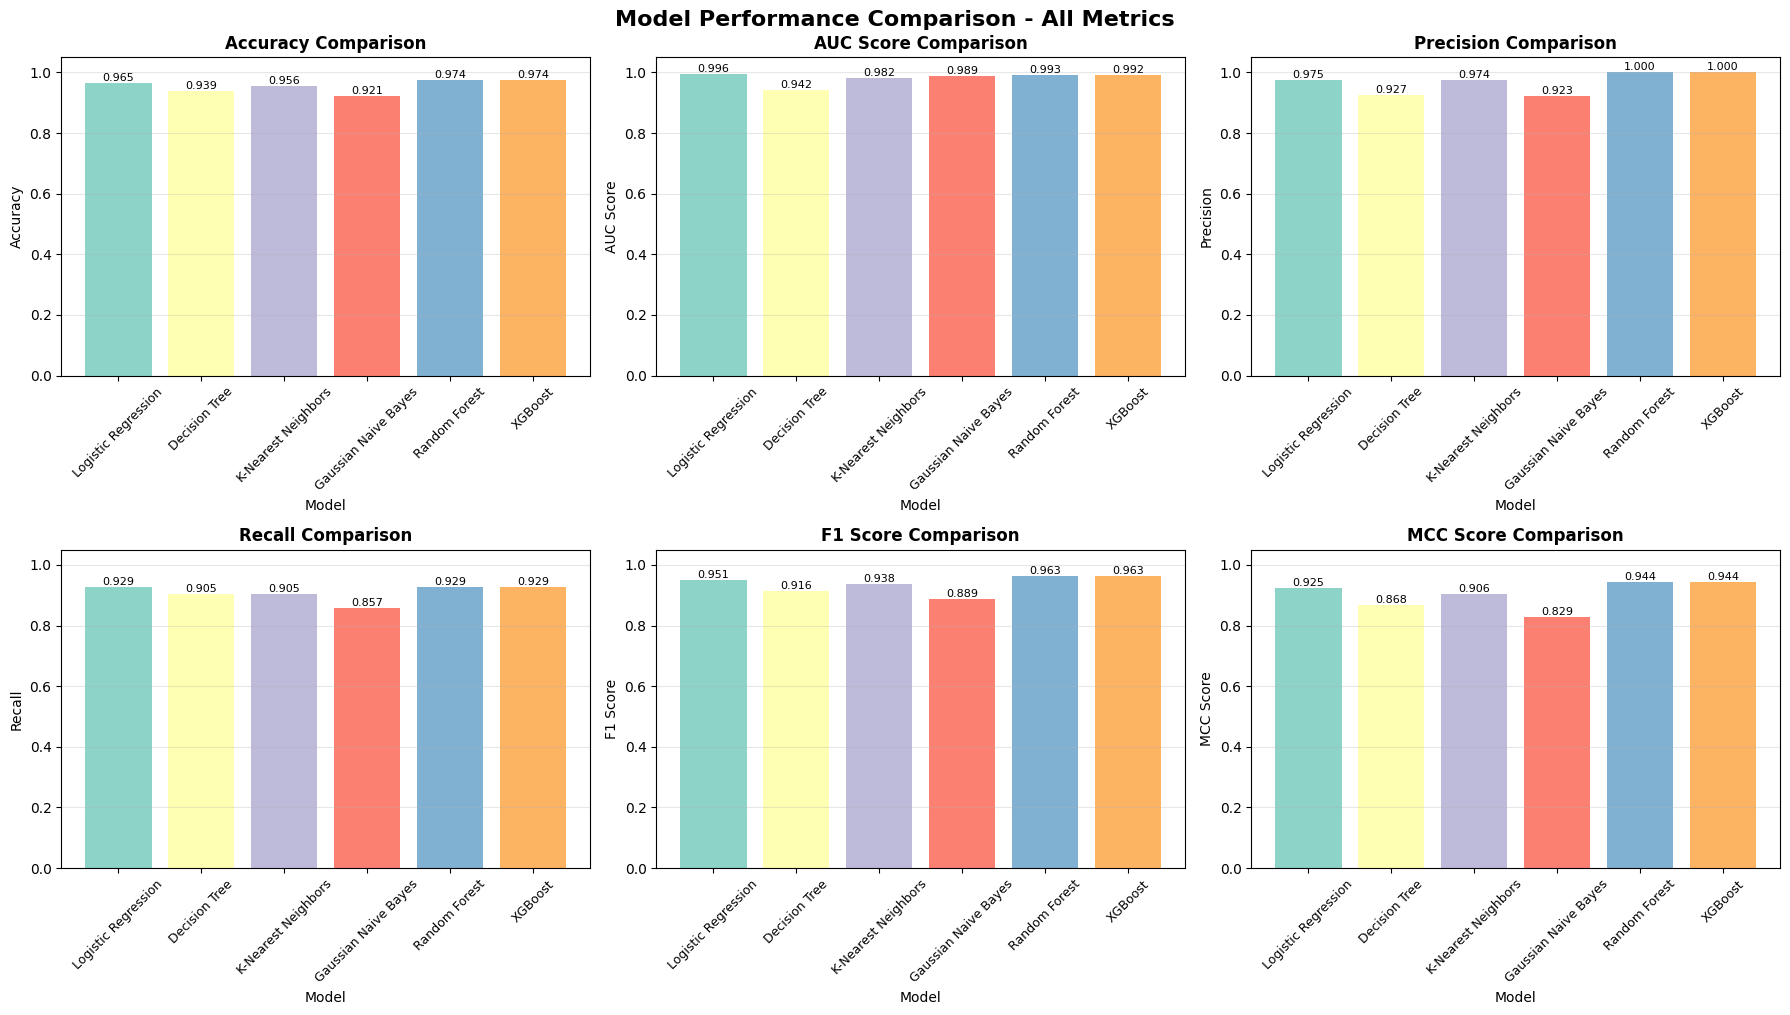

In [20]:
# Visualize model comparison - Bar charts for all metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

metrics = ['Accuracy', 'AUC Score', 'Precision', 'Recall', 'F1 Score', 'MCC Score']
colors = plt.cm.Set3(range(len(comparison_df)))

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    bars = ax.bar(comparison_df['Model'], comparison_df[metric], color=colors)
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric, fontsize=10)
    ax.set_xlabel('Model', fontsize=10)
    ax.tick_params(axis='x', rotation=45, labelsize=9)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.05])
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.suptitle('Model Performance Comparison - All Metrics', 
             fontsize=16, fontweight='bold', y=1.01)
plt.show()

## 13. ROC Curves Comparison

Plot ROC curves for all models to visualize their performance.

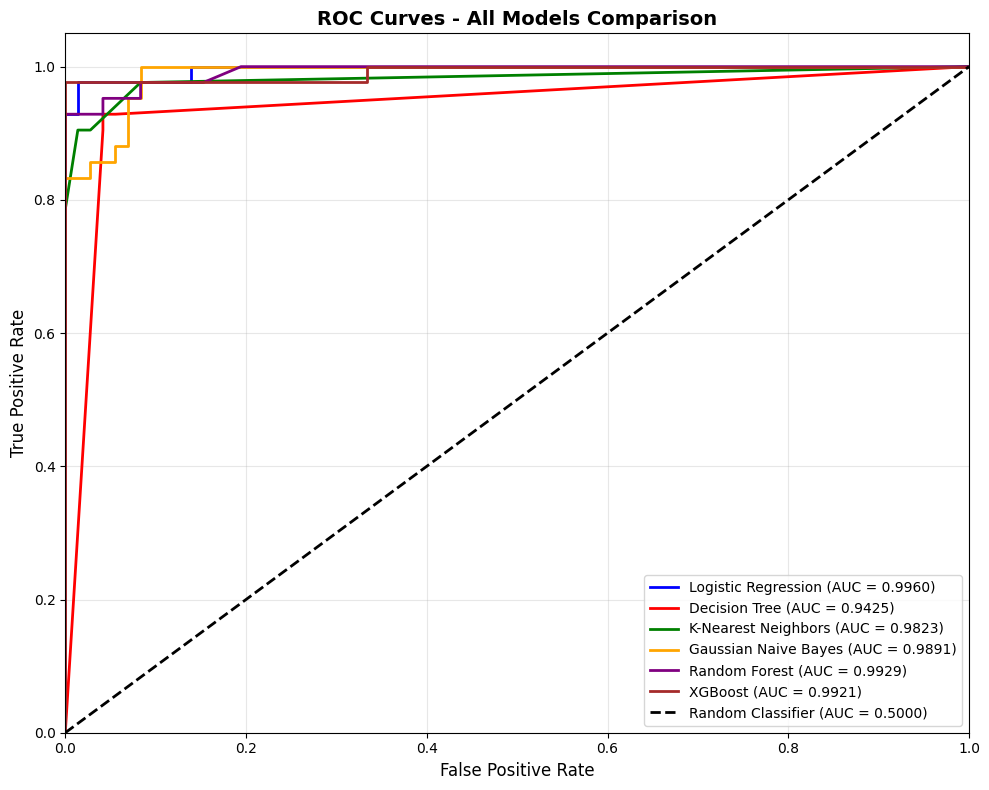

In [21]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']

for idx, result in enumerate(all_results):
    fpr, tpr, _ = roc_curve(y_test, result['Probabilities'])
    auc_score = result['AUC Score']
    plt.plot(fpr, tpr, color=colors[idx], lw=2, 
             label=f"{result['Model']} (AUC = {auc_score:.4f})")

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.5000)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - All Models Comparison', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()